# Inlet Analysis
Looking at how many inlets influence each node

In [6]:
import sys
sys.path.append('../')
from src.util import *
import numpy as np 
import snap
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt

### Load in the networks
Sanity check number of nodes and edges

In [10]:
G_LS174t = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/LS174T_clean_EdgesList.txt", 0, 1)
G_SW1222 = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/SW1222_clean_EdgesList.txt", 0, 1)
G_Healthy = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/Mesentery_clean_EdgeList.txt", 0, 1)

print "Healthy Network - Number of nodes: {}, Number of Edges {}".format(G_Healthy.GetNodes(), G_Healthy.GetEdges())
print "LS174T Tumour - Number of nodes: {}, Number of Edges {}".format(G_LS174t.GetNodes(), G_LS174t.GetEdges())
print "SW1222 Tumour - Number of nodes: {}, Number of Edges {}".format(G_SW1222.GetNodes(), G_SW1222.GetEdges())

Healthy Network - Number of nodes: 388, Number of Edges 539
LS174T Tumour - Number of nodes: 16354, Number of Edges 20377
SW1222 Tumour - Number of nodes: 64239, Number of Edges 77450


In [4]:
def generateInletCounts(G):
    inlets = getInletIds(G)
    nodeIds = [node.GetId() for node in G.Nodes()]
    inletCounts = collections.defaultdict(int)
    for inlet in tqdm(inlets):
        outSet = snap.GetBfsTree(G, inlet, True, False)
        for node in outSet.Nodes():
            inletCounts[node.GetId()] += 1
    return inletCounts

In [5]:
inletCounts = generateInletCounts(G_LS174t)
sortedCounts_LS = sorted(inletCounts.values())
xvals_LS = range(len(sortedCounts_LS))

100%|██████████| 1795/1795 [00:01<00:00, 936.45it/s]


In [6]:
inletCounts = generateInletCounts(G_SW1222)
sortedCounts_SW = sorted(inletCounts.values())
xvals_SW = range(len(sortedCounts_SW))

100%|██████████| 8170/8170 [00:42<00:00, 190.71it/s]


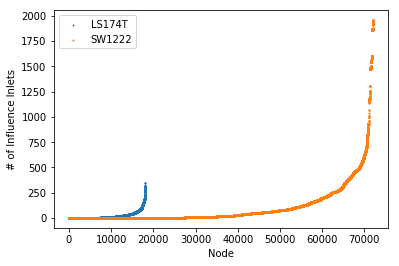

In [42]:
plt.scatter(xvals_LS, sortedCounts_LS, s=1, label='LS174T')
plt.scatter(xvals_SW, sortedCounts_SW, s=1, label='SW1222')
plt.xlabel('Node')
plt.ylabel('# of Influence Inlets')
plt.legend()

### Plot cumulative distribution that is normalised

In [44]:
inlets_LS = getInletIds(G_LS174t)
x = collections.Counter(sortedCounts_LS)
x_normalised_LS = [float(y)/G_LS174t.GetNodes() for y in x.keys()]
y_normalised_LS = [float(y)/len(inlets_LS) for y in x.values()]

print min(x_normalised_LS), max(x_normalised_LS)
print min(y_normalised_LS), max(y_normalised_LS)

5.52699939203e-05 0.0192892278782
0.000557103064067 2.4061281337


In [29]:
inlets_SW = getInletIds(G_SW1222)
x = collections.Counter(sortedCounts_SW)
x_normalised_SW = [float(y)/G_SW1222.GetNodes() for y in x.keys()]
y_normalised_SW = [float(y)/len(inlets_SW) for y in x.values()]

print min(x_normalised_SW), max(x_normalised_SW)
print min(y_normalised_SW), max(y_normalised_SW)

1.38727040675e-05 0.027135009156
0.000122399020808 2.16634026928


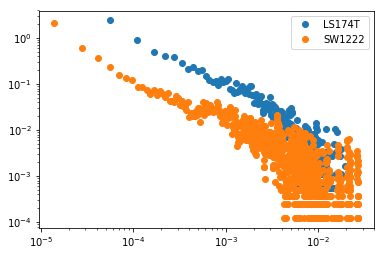

In [37]:
plt.plot(x_normalised_LS, y_normalised_LS,'o',label="LS174T")
plt.plot(x_normalised_SW, y_normalised_SW,'o', label="SW1222")
plt.xscale('log')
plt.yscale('log')
plt.legend()

## Connectivity

In [13]:
def getNodeConnectivityFrac(G, nodeId):
    total = snap.GetBfsTree(G, nodeId, True, False).GetNodes() +\
                snap.GetBfsTree(G, nodeId, False, True).GetNodes()
    return float(total)/G.GetNodes()

def getConnectivityList(G):
    return [getNodeConnectivityFrac(G, i.GetId()) for i in G.Nodes()]

In [14]:
LS_connectivity = getConnectivityList(G_LS174t)
SW_connectivity = getConnectivityList(G_SW1222)

In [15]:
LS_conn_log = [np.log(x) for x in LS_connectivity]
SW_conn_log = [np.log(x) for x in SW_connectivity]

In [16]:
min(SW_conn_log), min(LS_conn_log)

(-9.971753493206217, -8.603615506053814)

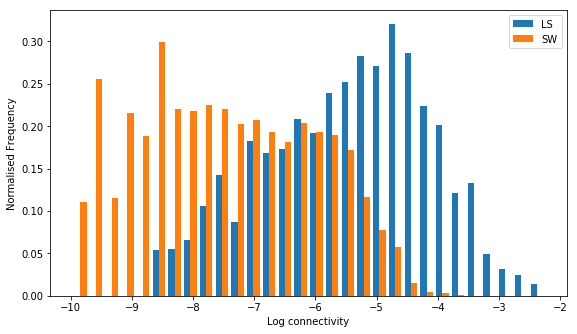

In [22]:
plt.hist([LS_conn_log, SW_conn_log], bins=30, normed=True, label=['LS','SW'])
plt.xlabel('Log connectivity')
plt.ylabel('Normalised Frequency')
plt.legend()
plt.gcf().set_size_inches(9.25, 5.25)
plt.savefig('../figs/connectivity.pdf')